<a href="https://colab.research.google.com/github/Albertogalred/Data-Science/blob/TFM/NeumoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ENTORNO DE GOOGLE Y OBTENCIÓN DE CÓDIGOS DE LOS ARCHIVOS DE DATOS**

In [3]:
!pip install keras

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

title: val.zip, id: 1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4
title: .ipynb_checkpoints, id: 1-2mIbiWIas_CexviyUBV0SDUNQNRSRT8
title: train.zip, id: 1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp
title: NeumoX, id: 1bSyXkNyzwrxPajbY-WNTiCCs4ycwcYnW
title: test.zip, id: 1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx
title: Colab Notebooks, id: 1Iz8nrdf6kHl5Jimc2xL9zcws8JEA1MUZ


In [6]:
# Download a file based on its file ID.
#

file_id = '1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

file_id = '1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("val.zip")

**CREACIÓN DE CARPETAS**

In [7]:
!mkdir NeumoX
!cd NeumoX && unzip -q ../train.zip
!cd NeumoX && unzip -q ../test.zip
!cd NeumoX && unzip -q ../val.zip

In [8]:
!pwd

/content


**IMPORTACION**

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input,ELU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix
from tqdm import tqdm  
import cv2   
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import h5py
import os, shutil
import glob
import time
import random


**PROCESADO DE IMÁGENES**

In [10]:
import cv2
total_images_train_normal = os.listdir('../content/NeumoX/train/NORMAL/')
total_images_train_pneumonia = os.listdir('../content/NeumoX/train/PNEUMONIA/')

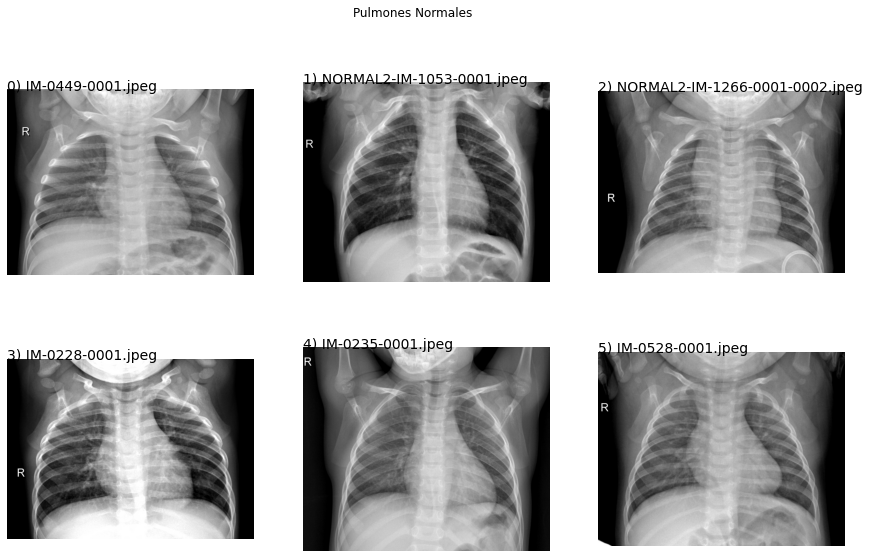

In [11]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    filename=sample_normal[i]
    im = cv2.imread('../content/NeumoX/train/NORMAL/' +sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones Normales')
plt.show()

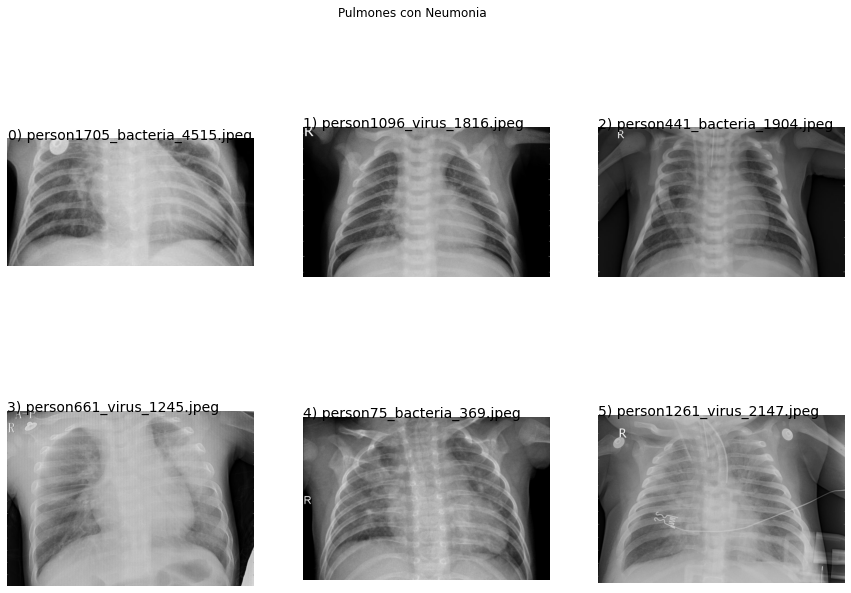

In [12]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,10))

for i in range(0,6):
    filename=sample_pneumonia[i]
    im = cv2.imread('../content/NeumoX/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones con Neumonia')
plt.show()

1341
3875


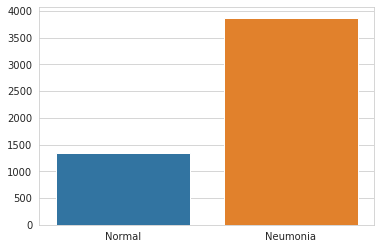

In [13]:
import seaborn as sns
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Neumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
print(len(total_images_train_normal))
print(len(total_images_train_pneumonia))

**TAMAÑO DE LAS IMÁGENES**

In [14]:
#os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_seed(1)

In [15]:

from tensorflow.keras import backend as K

img_width, img_height = 64, 64

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(64, 64, 1)

**MODELO TPU**

In [16]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

**GENERACIÓN DE LOTES DE IMÁGENES**

In [17]:
TRAIN_DIR = "../content/NeumoX/train/"
TEST_DIR =  "../content/NeumoX/test/"
VALID_DIR=  "../content/NeumoX/val/"

In [18]:
#Generadores Genericos que cojan las imagenes del disco
from keras.preprocessing import image
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
validation_datagen=image.ImageDataGenerator(rescale=1./255.0)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

In [19]:
#Generadores Genericos que cojan las imagenes del disco
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("../content/NeumoX/train/",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("../content/NeumoX/val/", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("../content/NeumoX/test/", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**MODELO**

In [21]:
def create_model():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(128, (3, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))

    return model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy])

INFO:tensorflow:Initializing the TPU system: grpc://10.89.1.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.1.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [28]:
history = model.fit(train_batches,validation_data=test_batches,epochs=30, steps_per_epoch=100, validation_freq=20)



NotImplementedError: ignored